## Import libraries

In [1]:
import cv2 as cv
import numpy as np
import jupyter_show_image as imshow
from PIL import Image
import scipy.linalg as la

## Open image

In [2]:
metro = np.array(Image.open('images/arret_avec_metro.jpg'))
arret = np.array(Image.open('images/arret.jpeg'))

## Train detection

In [3]:
# Convert images to grayscale
grayMetro = cv.cvtColor(np.copy(metro), cv.COLOR_BGR2GRAY)
grayArret = cv.cvtColor(np.copy(arret), cv.COLOR_BGR2GRAY)


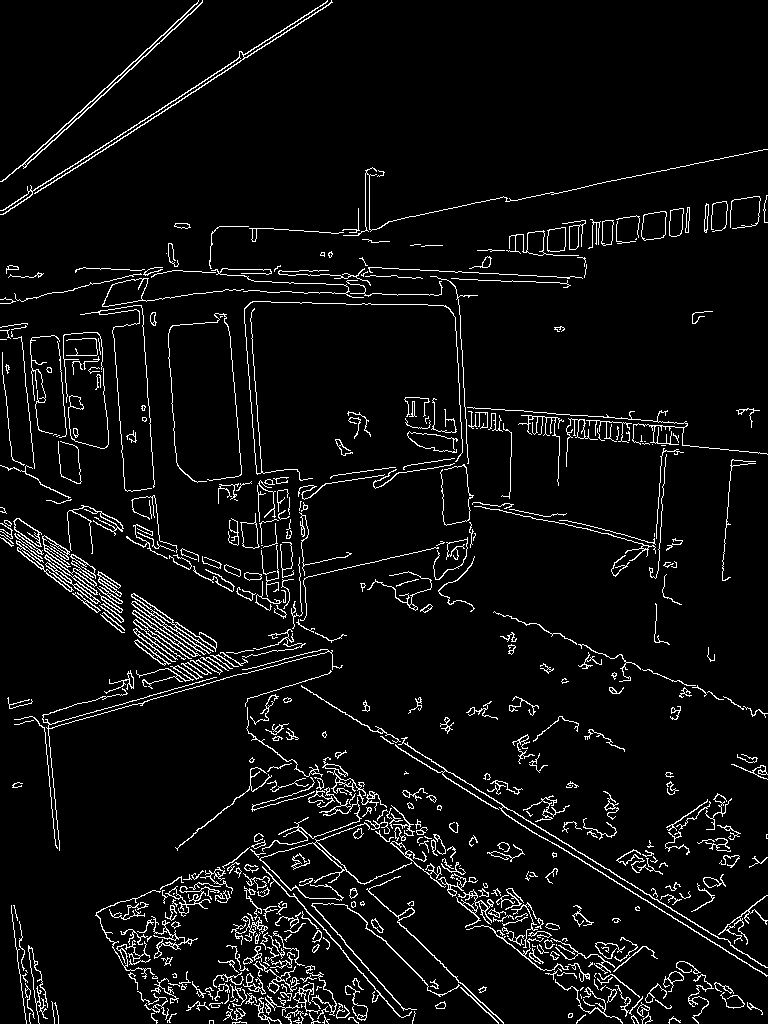
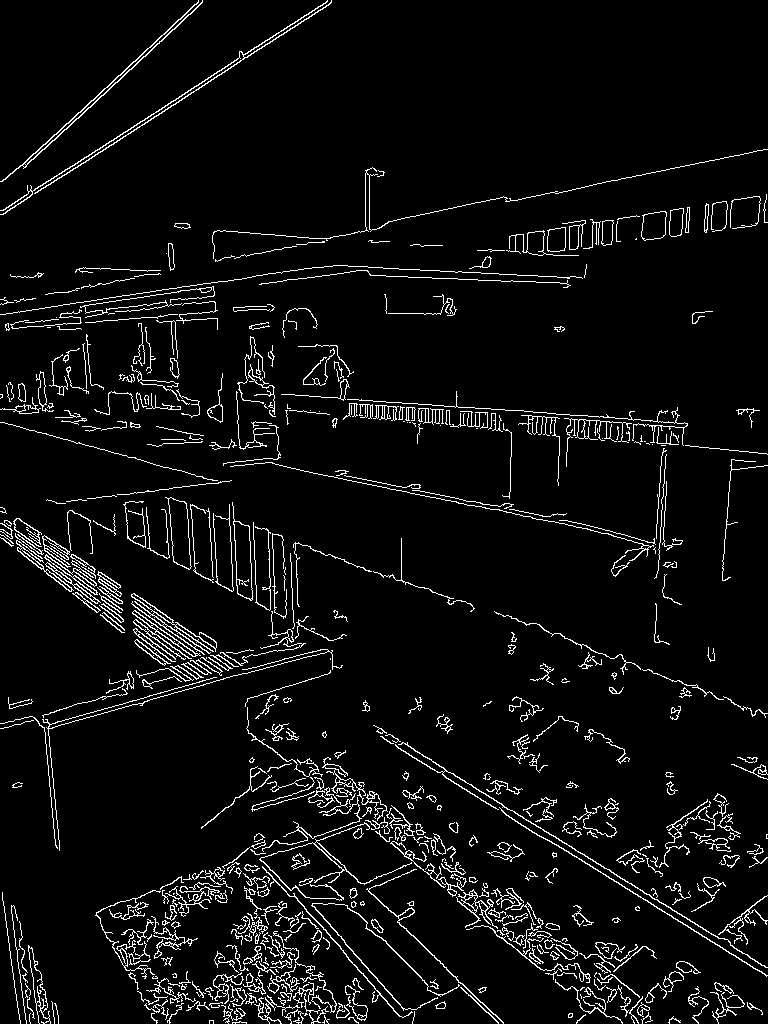
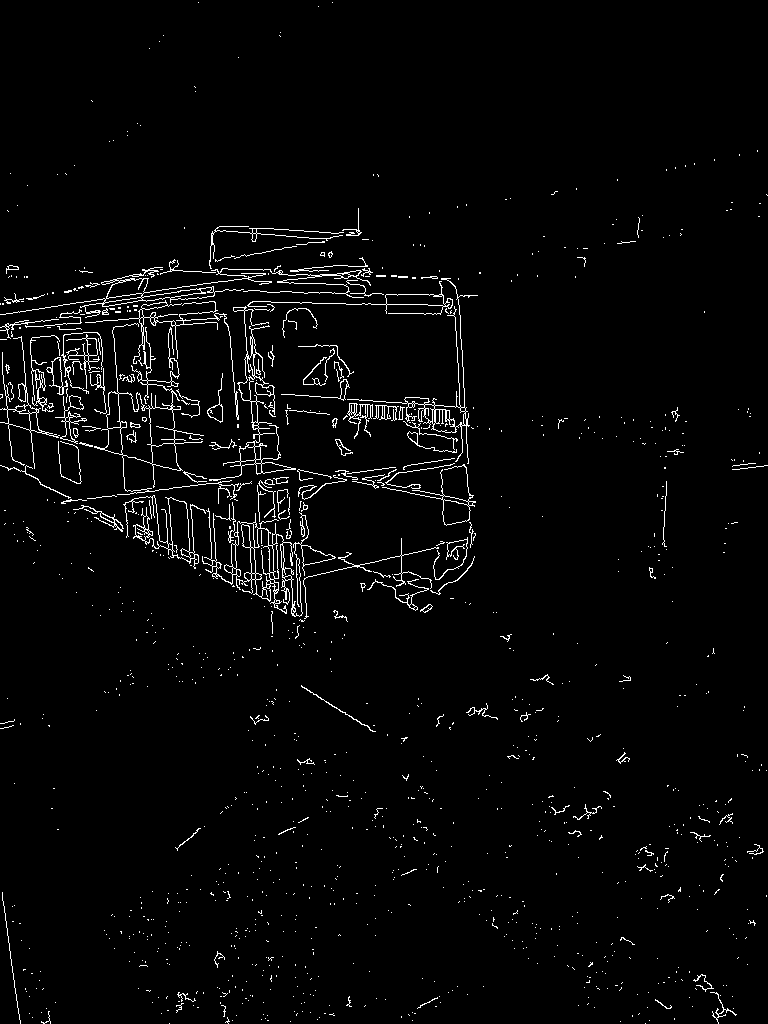

In [4]:
max_lowThreshold = 100
low_threshold = 80
ratio = 3
kernel_size = 3

metro_blur = cv.blur(grayMetro, (4,4))
metro_detected_edges = cv.Canny(metro_blur, low_threshold, low_threshold*ratio, kernel_size)
metro_mask = metro_detected_edges != 0

arret_blur = cv.blur(grayArret, (4,4))
arret_detected_edges = cv.Canny(arret_blur, low_threshold, low_threshold*ratio, kernel_size)
arret_mask = arret_detected_edges != 0


mask = cv.bitwise_xor(metro_mask.astype(metro.dtype), arret_mask.astype(metro.dtype), mask = None) 
kernel_dilate = np.ones((3,3),np.float32)
kernel_open = np.ones((5,5),np.float32)

imshow.show([metro_mask, arret_mask, mask], fmt='png')

## Use connected components to get rid of noise


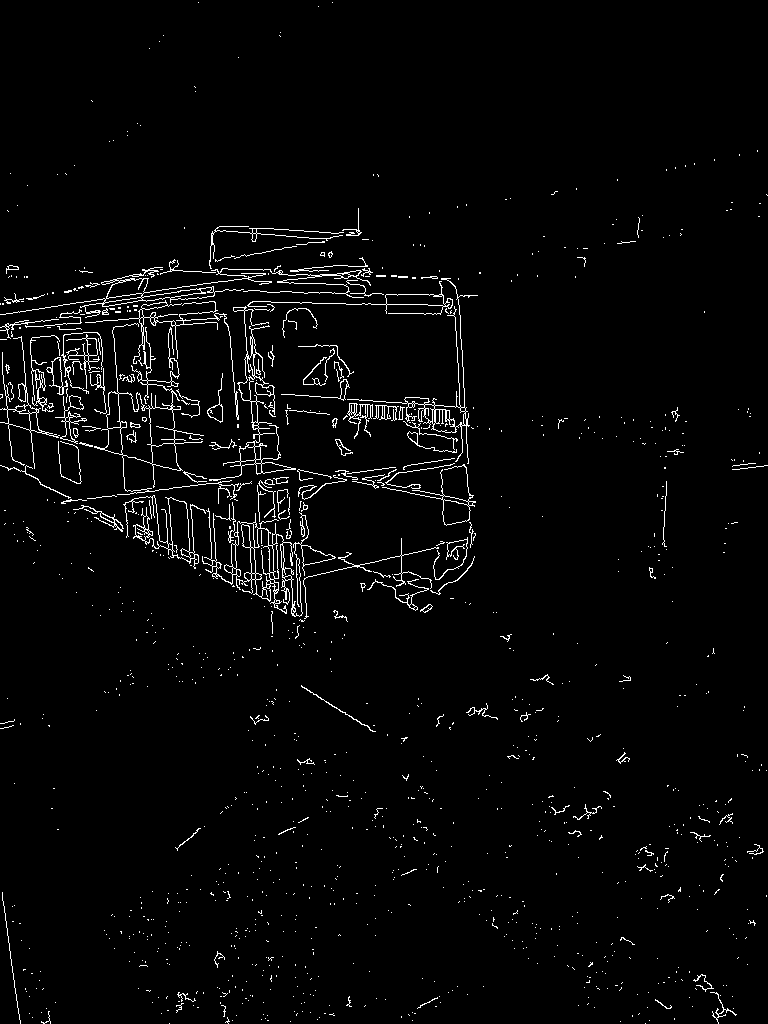
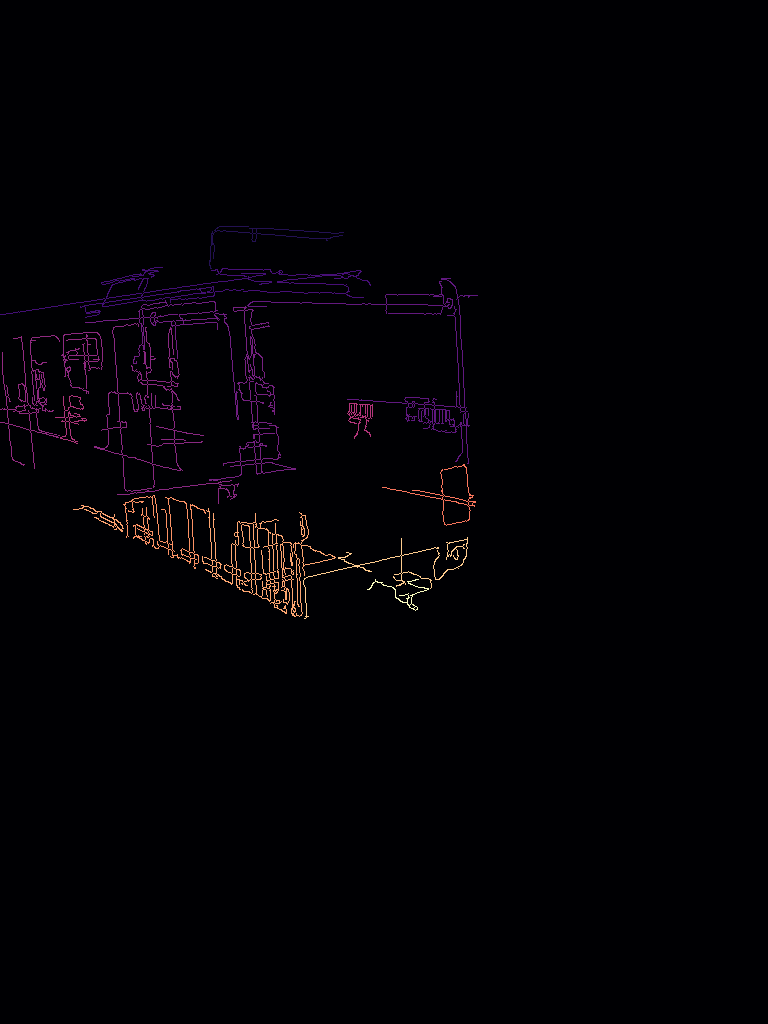

In [5]:
num_labels, labels = cv.connectedComponents(mask)
cc_count = np.bincount(np.ravel(labels)) # Find the size of each connected component
threshold = 150 # Min size of connected component

# Delete connected components smaller than what we want
for (i, count) in enumerate(cc_count):
    if count < threshold:
        labels[labels == i] = 0
        num_labels -= 1

imshow.show([mask, labels], fmt='png')

## Join connected components
Set all connected components to the same number, as if they represented one big connected component and then find bounding boxes around it.


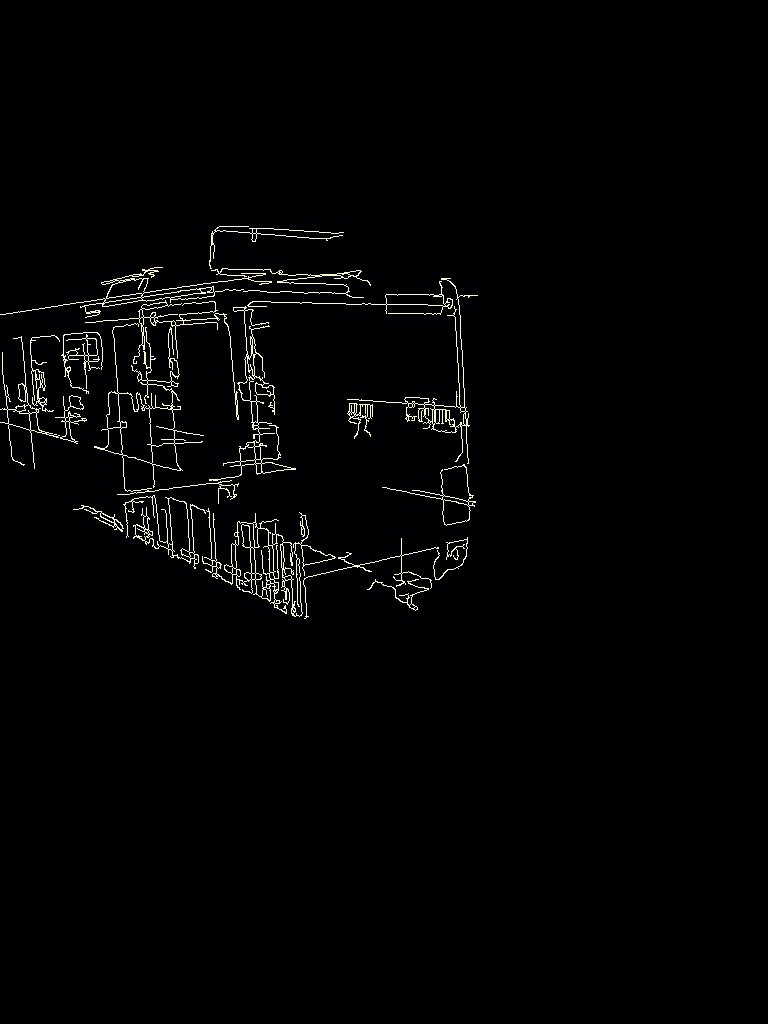

In [6]:
labels[labels != 0] = 1
num_labels = 1
imshow.show(labels, fmt='png')

## Set bounding box around the train and display

In [7]:
# Recover points of the connected component
train = np.argwhere(labels == 1)
train = train[:, [1,0]] # Reverse x and y components
x, y, width, height = cv.boundingRect(train)
box_color = (255, 0, 0)
result = np.copy(metro)
result = cv.rectangle(result, (x, y), (x + width, y + height), box_color, 2)

## Approximating the dock line through camera - world transformation
For this we need to know the distance (d) of the camera from the dock, the height at which it is placed and the yaw (theta) and pitch (alpha) angles. From the distance and height, we will establish the translation and the angles will give us the rotation. With this method, we are able to get the x-distance of the train from the camera, and knowing where the camera is in the dock, we can therefore know where the train is relative to the dock.
The origin is at the ground below the camera level.
The size of the line we will draw depends on the FOV of the camera. It will be the width of the FOV at distance d from the camera.

In [8]:
# Camera parameters from our implementation
theta = 100 # Degrees
alpha = 10 # Degrees
height = 1.8 # In meters
distance = 1.5 # In meters
h_FOV = 4 # In meters

# Yaw rotation matrix
rot_yaw = np.zeros((4,4))
rot_yaw[0,0] = 1
rot_yaw[3,3] = 1
rot_yaw[1,1] = np.cos(theta)
rot_yaw[2,2] = np.cos(theta)
rot_yaw[2,1] = np.sin(theta)
rot_yaw[1,2] = -np.sin(theta)

# Pitch rotation matrix
rot_pitch = np.zeros((4,4))
rot_pitch[1,1] = 1
rot_pitch[3,3] = 1
rot_pitch[0,0] = np.cos(theta)
rot_pitch[2,2] = np.cos(theta)
rot_pitch[0,2] = np.sin(theta)
rot_pitch[2,0] = -np.sin(theta)

# Translation matrix
translate = np.zeros((4,4))
for i in range(3):
    translate[i,i] = 1
translate[0,3] = distance
translate[1,3] = 0
translate[2,3] = height

# Original line (defined by connecting the points of the two extrema)
p1 = np.array([-h_FOV, 0, 0, 1])
p2 = np.array([h_FOV, 0, 0, 1])

t_p1 = rot_yaw @ translate @ rot_pitch @ p1
t_p2 = rot_yaw @ translate @ rot_pitch @ p2

# Translate real life dimensions to the image
v_img = result.shape[0]
h_img = result.shape[1]
proportion = h_img/h_FOV # How many pixels per meter
t_p1 = t_p1 * proportion
t_p2 = t_p2 * proportion

# To have values relative to the camera origin again, we need to translate the points
origin_translation = np.array([int(h_img/2), 0, int(v_img/2) , 0])
t_p1 += origin_translation
t_p2 += origin_translation

# Round the vectors to their nearest integer
t_p1 = t_p1.astype('int32')
t_p2 = t_p2.astype('int32')

final = cv.line(np.copy(result), (t_p1[0],t_p1[2]), (t_p2[0],t_p2[2]), (0,0,255), 2)

## Plot result of line transformation


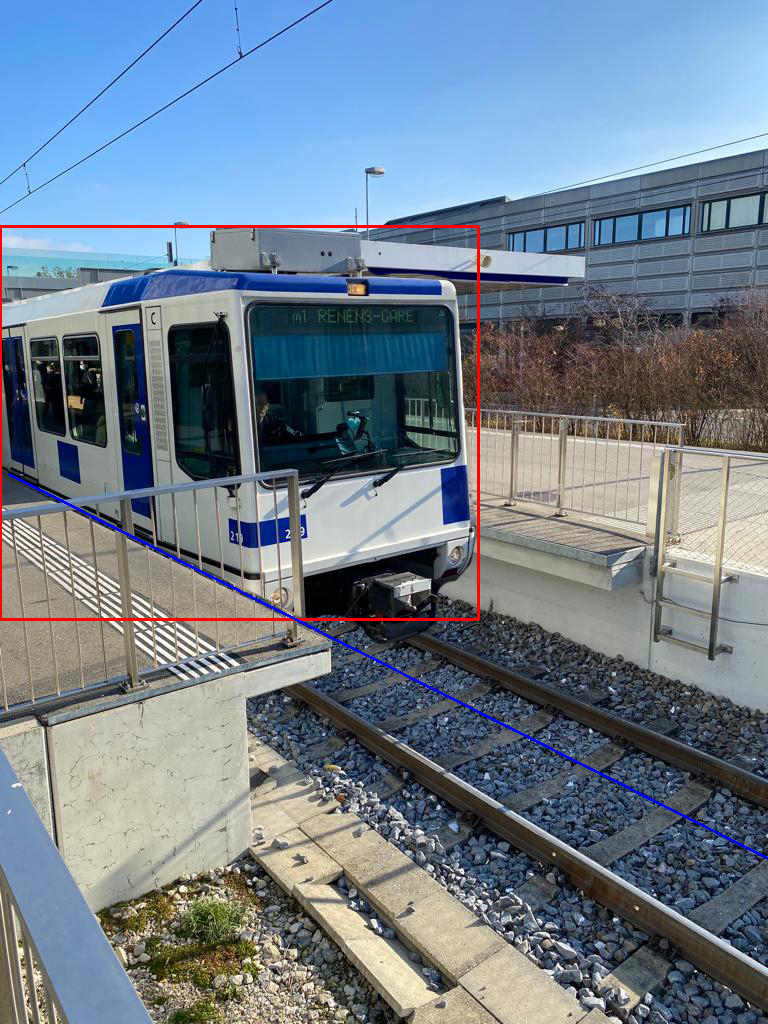

In [9]:
imshow.show(final, fmt='png') # Display image

## Find intersection between bounding box and line and take inverse trasnformation
To draw the bounding box we needed the top left and right bottom corners. So, to obtain the line that crosses the dock line, we need the bottom line of the bounding box. We also know this line is horizontal and therefore has no slope, so we only need to get its bias to have the line equation. With this line and the blue one, we solve a small system of linear equations in order to get their intersection. As the y-coordinate is constant for the red line, we just need to figure out the x-coordinate.

In [11]:
# Red line
red_bias = y - height
y_red = red_bias

# Blue line
blue_slope = (t_p2[2] - t_p1[2])/float(t_p2[0] - t_p1[0])
blue_bias = t_p1[2] - blue_slope*t_p1[0] #y = a*x + b <=> b = y - a*x

# Solution : a*x + b = y_red <=> a*x = y_red - b <=> x = (y_red - b)/a (becuase we know a to be != 0)
t_x = (y_red - blue_bias)/float(blue_slope)

# Transform it into a compatible format
t_x = np.array([t_x, 0, y_red, 1])

# Transform the solution back to the camera referential by finding best approximation of Ax = b
A = rot_yaw @ translate @ rot_pitch
b = t_x

# Calculating terms for normal equations
A_t_A = A.T @ A
A_t_b = A.T @ b

# Use LU to solve for normal equations
lu, piv = la.lu_factor(A_t_A)
x = la.lu_solve((lu, piv), A_t_b)

# Go back from pixel metrics to meters
x = x/proportion

# Display the result
print(x)

[-0.93012326 -0.59128738  2.40968795 -0.33333333]


## Conclusions
We want to focus on the first coordinate, which is the x-coordinate. The final answer represents the position of the train relative to the position of the camera (which was the initial referential). We can see it is negative as expected and that the calculations show the train stops ~1 meter before the position of the camera. This doesn't seem very accurate (as the train seems at least 2m before the camera), but that is simply due to the fact that we didn't have any precise measurements, so by taking that into account, I would say the results we got are pretty impressive.